# IsoTools Hands-on Practice

This practical exercise has been designed for the LongTREC bioinformatics summer school in Long-reads transcriptomics.

IsoTools

- GitHub repository: https://github.com/HerwigLab/IsoTools2
- Documentation and tutorial: https://isotools.readthedocs.io/en/latest/index.html
- pip package: https://pypi.org/project/isotools/

This practice include:

- transcriptome reconstruction
- data export
- gene model characteristics
- alternative splicing analysis and differential splicing analysis

To reduce the running time, we only consider a subset of chromosome 8 for demonstration purposes. This was done using `samtools`.

First, import all the dependencies.

In [1]:
from isotools import Transcriptome
from isotools._transcriptome_io import write_fasta
from isotools.plots import plot_diff_results, plot_embedding, plot_str_var_number, triangle_plot
from isotools import __version__ as isotools_version

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger = logging.getLogger('isotools')

logger.info(f'This practice uses IsoTools version {isotools_version}.')

INFO:This practice uses IsoTools version 2.0.0.


Specify the path to the directory in which the demonstration data and reference are saved. Create a folder to save the output files.

In [2]:
path = os.getcwd()

out_dir = os.path.join(path, 'output')
os.makedirs(out_dir, exist_ok=True)

## Transcriptome reconstruction

to reconstruct the transcriptome from sample reads.

For this exercise, we require the following input files:

- genome sequence in `fasta` format (human genome GRCh38.p14 downloaded from Gencode)
- reference annotation in `gtf` or `gff3` format, sorted and indexed (Gencode v45)
- long-read alignments in `bam` format and corresponding index (raw fastq files downloaded from Encode)

### Import of reference annotation

to initiate the transcriptome object.

In [3]:
ref_gtf = "reference/gencode.v45.chr8.gtf"

transcriptome = Transcriptome.from_reference(ref_gtf)

INFO:importing reference from gtf file reference/gencode.v45.chr8.gtf
INFO:skipped the following categories: dict_keys(['UTR', 'CDS'])


### Import of sample data

We need to know the sample names as well as the corresponding alignment file names and group assignment, which are saved in the file `sample_table_chr8.txt`, in order to tell IsoTools where to find the sample read files and which groups they belong to.

First, we import this sample annotation table.

In [4]:
samples = pd.read_csv(f'{path}/sample_table_chr8.txt', sep='\t')

samples

,id,file,group
0,cDNA_PacBio-endo_1,data/ENCFF731HST_aligned_chr8.bam,endo
1,cDNA_PacBio-endo_2,data/ENCFF712CBL_aligned_chr8.bam,endo
2,cDNA_PacBio-endo_3,data/ENCFF235QXW_aligned_chr8.bam,endo
3,cDNA_PacBio-h1_1,data/ENCFF853OFP_aligned_chr8.bam,h1
4,cDNA_PacBio-h1_2,data/ENCFF436GKZ_aligned_chr8.bam,h1
5,cDNA_PacBio-h1_3,data/ENCFF400BQQ_aligned_chr8.bam,h1


The 'h1' refers to the H1 human embryonic stem (hES) cell line. These cells are undifferentiated and have the ability to develop into any cell type.

The 'endo' refers to definitive endoderm derived from H1. These cells can differentiate into various endoderm-derived cell types, including those found in the liver, pancreas and lungs.

These two cell lines are at different developmental stages. There are three biological replicates of each.

Next, we start to import the sequencing data and reconstruct the transcriptome.

In [5]:
for _,row in samples.iterrows():
    transcriptome.add_sample_from_bam(row["file"], sample_name=row["id"], group=row["group"], progress_bar=False)

INFO:adding sample cDNA_PacBio-endo_1 from file data/ENCFF731HST_aligned_chr8.bam
[W::hts_idx_load3] The index file is older than the data file: data/ENCFF731HST_aligned_chr8.bam.bai
INFO:skipped 102 reads aligned fraction of less than 0.75.
INFO:skipped 10001 secondary alignments (0x100), alignment that failed quality check (0x200) or PCR duplicates (0x400)
INFO:ignoring 437 chimeric alignments with less than 2 reads
INFO:imported 38652 nonchimeric reads (including  102 chained chimeric alignments) and 5 chimeric reads with coverage of at least 2.
INFO:adding sample cDNA_PacBio-endo_2 from file data/ENCFF712CBL_aligned_chr8.bam
[W::hts_idx_load3] The index file is older than the data file: data/ENCFF712CBL_aligned_chr8.bam.bai
INFO:skipped 84 reads aligned fraction of less than 0.75.
INFO:skipped 13242 secondary alignments (0x100), alignment that failed quality check (0x200) or PCR duplicates (0x400)
INFO:ignoring 667 chimeric alignments with less than 2 reads
INFO:imported 49666 nonc

As you can see here in IsoTools, we have quality control of the alignments. Cleaner alignments reduce the number of reads that are discarded.

During transcriptome reconstruction, IsoTools also detects chimeric reads, also known as split reads.

These indicate structural variation and mean that one sequencing read aligns to two distinct portions of the genome with little or no overlap.

![chimeric read](https://www.drive5.com/usearch/manual/chimera.gif)

For this analysis, we will focus on the non-chimeric reads.

Let's take a look at how many reads have been imported.

In [6]:
transcriptome.sample_table

,name,file,group,nonchimeric_reads,chimeric_reads
0,cDNA_PacBio-endo_1,data/ENCFF731HST_aligned_chr8.bam,endo,38652,5
1,cDNA_PacBio-endo_2,data/ENCFF712CBL_aligned_chr8.bam,endo,49666,7
2,cDNA_PacBio-endo_3,data/ENCFF235QXW_aligned_chr8.bam,endo,48416,5
3,cDNA_PacBio-h1_1,data/ENCFF853OFP_aligned_chr8.bam,h1,21579,4
4,cDNA_PacBio-h1_2,data/ENCFF436GKZ_aligned_chr8.bam,h1,44054,2
5,cDNA_PacBio-h1_3,data/ENCFF400BQQ_aligned_chr8.bam,h1,8296,0


Let's have a look at the group information, and define colors for groups for visualisation later on.

In [7]:
groups = transcriptome.groups()

groups

{'endo': ['cDNA_PacBio-endo_1', 'cDNA_PacBio-endo_2', 'cDNA_PacBio-endo_3'],
 'h1': ['cDNA_PacBio-h1_1', 'cDNA_PacBio-h1_2', 'cDNA_PacBio-h1_3']}

In [8]:
# choose the colors for the groups

group_colors = {'h1': '#f28e2b', 'endo': 'rebeccapurple'}

## Quality control and filtering

Quality control is important for downstream analysis. IsoTools has a built-in function to compute quality control metrics based on the genetic features of reads. It measures:

- downstream A content
- direct repeat length at junctions
- noncanonical splicing
- potential fragments


In [9]:
genome_fn = f'{path}/reference/GRCh38.p14.chr8.fa'

transcriptome.add_qc_metrics(genome_fn, correct_tss=False)

100%|███████████████████████████████████| 5377/5377 [00:29<00:00, 185.28genes/s]


We want to remove low-quality transcripts and retain high-quality ones for downstream analysis. IsoTools implements transcript filtering using a flexible query syntax based on logical combinations of tags, which are by convention a single word in capital letters.

Some predefined tags are available in IsoTools for common technical artifacts, which are detected based on minimal coverage and the genetic features mentioned above. These include:

- Internal priming (IP): unspliced and downstream adenosine content of at least 50%.
- Reverse transcriptase template switching (RTTS): non-canonical splicing where neither splice site is in the reference.
- Fragments: transcripts contained within other transcripts with no TSS/PAS overlap with the reference annotation.

<img src="https://www.researchgate.net/publication/337117264/figure/fig3/AS:962623642300428@1606518769874/The-mechanisms-of-internal-priming-and-template-switching-a-Internal-priming-occurs.png" width="400">

In [10]:
# predefined tags to detect technical artifacts
artifact_tags = ['INTERNAL_PRIMING', 'RTTS', 'FRAGMENT']

for tag in artifact_tags:
    print(f'{tag}: {transcriptome.filter["transcript"][tag]}')

INTERNAL_PRIMING: len(exons)==1 and downstream_A_content and downstream_A_content>.5
RTTS: noncanonical_splicing is not None and novel_splice_sites is not None and         any(2*i in novel_splice_sites and 2*i+1 in novel_splice_sites for i,_ in noncanonical_splicing)
FRAGMENT: fragments and any("novel exonic " in a or "fragment" in a for a in annotation[1])


Based on previous experience, we typically observe around 10-15% of artifact transcripts.

What percentage of the transcripts in each group are artifacts?

In [11]:
transcriptome.filter_stats(tags=artifact_tags, groups=groups, weight_by_coverage=False)

(                    endo      h1
 total             5470.0  3109.0
 PASS              4574.0  2678.0
 FRAGMENT           719.0   352.0
 INTERNAL_PRIMING   117.0    49.0
 RTTS                62.0    30.0,
 {'ylabel': 'fraction of different transcripts',
  'title': 'Different Transcripts > 2 reads'})

What percentage of the transcripts in each group are novels?

Hint: the tag for a 'novel transcript' is 'NOVEL_TRANSCRIPT'.

In [12]:
transcriptome.filter_stats(tags=['NOVEL_TRANSCRIPT'], groups=groups, weight_by_coverage=False)

(                    endo      h1
 total             5470.0  3109.0
 NOVEL_TRANSCRIPT  4348.0  2205.0
 PASS              1122.0   904.0,
 {'ylabel': 'fraction of different transcripts',
  'title': 'Different Transcripts > 2 reads'})

Quality control is essential for meaningful biological analysis!

There are predefined tags for filtering based on coverage and on whether a transcript is affected by technical artifacts.

In [13]:
for tag in ['HIGH_COVER', 'PERMISSIVE', 'BALANCED', 'STRICT']:
    print(f'{tag}: {transcriptome.filter["transcript"][tag]}')

HIGH_COVER: gene.coverage.sum(0)[trid] >= 7
PERMISSIVE: gene.coverage.sum(0)[trid] >= 2 and (FSM or not (RTTS or INTERNAL_PRIMING or FRAGMENT))
BALANCED: gene.coverage.sum(0)[trid] >= 2 and (FSM or (HIGH_COVER and not (RTTS or FRAGMENT or INTERNAL_PRIMING)))
STRICT: gene.coverage.sum(0)[trid] >= 7 and SUBSTANTIAL and (FSM or not (RTTS or FRAGMENT or INTERNAL_PRIMING))


We will use 'BALANCED' for demonstration in this practice. It's possible to customise the query depending on your needs.

In [14]:
query_string = 'BALANCED'

Create a table summarising the transcripts that passed the filtering.

In [15]:
transcript_tab = transcriptome.transcript_table(groups=groups, query=query_string, coverage=True)

transcript_tab

,chr,transcript_start,transcript_end,strand,gene_id,gene_name,transcript_nr,transcript_length,num_exons,exon_starts,exon_ends,novelty_class,novelty_subclasses,endo_sum_coverage,h1_sum_coverage
0,chr8,15540262,15764484,+,ENSG00000104723.21,TUSC3,0,1478,10,"15540262,15623079,15650696,15659506,15662155,1...","15540568,15623249,15650814,15659647,15662296,1...",FSM,FSM,128,37
1,chr8,15540262,15758275,+,ENSG00000104723.21,TUSC3,1,1507,11,"15540262,15623079,15650696,15659506,15662155,1...","15540568,15623249,15650814,15659647,15662296,1...",NIC,novel combination,11,7
2,chr8,15540262,15764484,+,ENSG00000104723.21,TUSC3,2,1543,11,"15540262,15623079,15650696,15659506,15662155,1...","15540568,15623249,15650814,15659647,15662296,1...",FSM,FSM,59,13
3,chr8,15540262,15764648,+,ENSG00000104723.21,TUSC3,7,1551,9,"15540262,15623079,15650696,15659506,15662155,1...","15540568,15623249,15650814,15659647,15662296,1...",FSM,FSM,5,3
4,chr8,15761117,15764484,+,ENSG00000104723.21,TUSC3,13,3367,1,15761117,15764484,ISM,mono-exon,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,chr8,123319853,123396430,-,ENSG00000156802.13,ATAD2,8,6302,27,"123319853,123322937,123325892,123328189,123333...","123321175,123323066,123326026,123328579,123334...",NIC,intron retention,5,3
2448,chr8,85245706,85284071,+,ENSG00000185015.8,CA13,3,3633,7,"85245706,85250739,85259420,85266607,85267901,8...","85245865,85250937,85259539,85266703,85267964,8...",FSM,FSM,2,2
2449,chr8,30995803,31033309,-,ENSG00000172733.12,PURG,0,1996,3,"30995803,31031918,31033077","30996697,31032788,31033309",NIC,novel combination,7,3
2450,chr8,31027656,31030613,-,ENSG00000172733.12,PURG,3,2957,1,31027656,31030613,FSM,FSM,4,2


Basic statistics about the transcriptome after selection:

- how many transcripts?
- how many genes?
- how many transcripts per gene on average?

## Transcriptome export

IsoTools supports the export of the transcriptome in different formats.

1. pickle file: it contains the entire transcriptome data, which can be restored in an IsoTools session without re-importing the alignment files.

In [16]:
transcriptome.save(f'{out_dir}/h1_endo_chr8.pkl')

INFO:saving transcriptome to /home/train/longTREC/day2/isotools/output/h1_endo_chr8.pkl


If you need to import the pickle file later, please try:

In [17]:
transcriptome = Transcriptome.load(f'{out_dir}/h1_endo_chr8.pkl')

INFO:loading transcriptome from /home/train/longTREC/day2/isotools/output/h1_endo_chr8.pkl


2. GTF (General Feature Format) + expression matrix: you can apply filters and export only transcripts that have passed the filter.

In [18]:
transcriptome.write_gtf(f'{out_dir}/h1_endo_chr8_{query_string}.gtf', source='isotools', query=query_string, gzip=False)

INFO:writing gtf file to /home/train/longTREC/day2/isotools/output/h1_endo_chr8_BALANCED.gtf


In [19]:
transcript_tab.to_csv(f'{out_dir}/h1_endo_chr8_{query_string}.txt', sep='\t', index=False)

3. fasta: you can also export the sequences of selected transcripts in fasta file format.

In [20]:
transcriptome.write_fasta(genome_fn=genome_fn,
                          fn=f'{out_dir}/h1_endo_chr8_{query_string}.fasta',
                          query=query_string)

INFO:writing fasta file to /home/train/longTREC/day2/isotools/output/h1_endo_chr8_BALANCED.fasta


## Gene model characteristics

### Transcript identification - structural variation

From transcript identification, it is known which transcripts map to which genes. There are usually more than one transcript per gene. They exhibit some variation in structure.

This structural variation comes from the transcription start site (TSS), the exon chain, and the polyadenylation site (PAS). Let's take a closer look.

/home/train/longTREC/software/miniconda3/envs/isotools/lib/python3.12/site-packages/isotools/_transcriptome_stats.py:818: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  str_var_tab = str_var_tab.replace(0, np.nan)


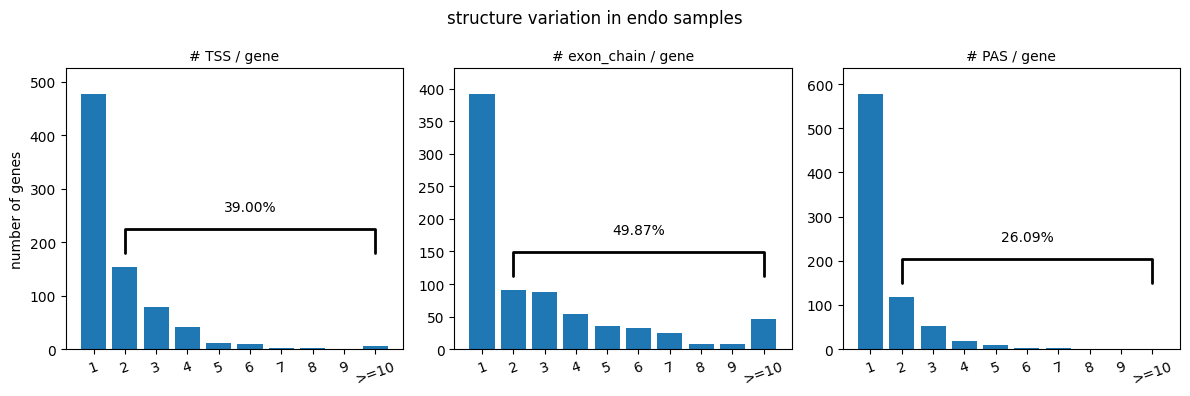

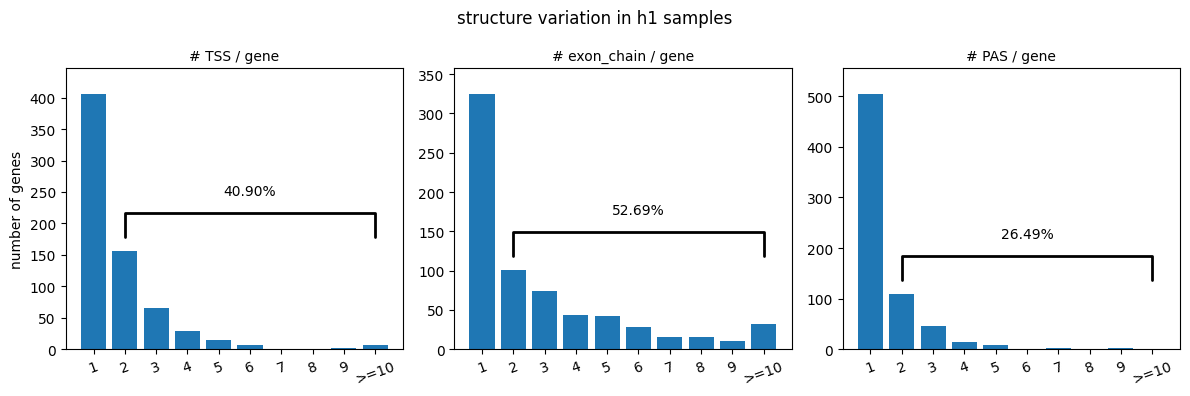

In [21]:
str_var_count = transcriptome.str_var_calculation(groups=groups, query=query_string, strict_ec=0, strict_pos=15, count_number=True)

for gn in str_var_count.columns[~str_var_count.columns.str.startswith('gene')].str.replace('_tss|_ec|_pas', '', regex=True).unique():
    fig = plot_str_var_number(str_var_count, group_name=gn)

We normalise the number of different TSSs, exon chains and PASs of a gene to simplex coordinates, which can then be used for visualisation in a triangle plot.

In [22]:
str_var_tab = transcriptome.str_var_calculation(groups=groups, query=query_string, strict_ec=0, strict_pos=15)

str_var_tab

/home/train/longTREC/software/miniconda3/envs/isotools/lib/python3.12/site-packages/isotools/_transcriptome_stats.py:812: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  str_var_tab = pd.concat(


,gene_id,gene_name,endo_tss,endo_ec,endo_pas,h1_tss,h1_ec,h1_pas
0,ENSG00000104723.21,TUSC3,0.260870,0.217391,0.521739,0.260870,0.217391,0.521739
1,ENSG00000172164.15,SNTB1,0.450000,0.100000,0.450000,0.450000,0.100000,0.450000
2,IT_novel_00170,IT_novel_00170,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
3,ENSG00000253200.1,ENSG00000253200,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
4,ENSG00000261236.8,BOP1,0.200000,0.600000,0.200000,0.200000,0.600000,0.200000
...,...,...,...,...,...,...,...,...
795,ENSG00000131203.13,IDO1,0.303030,0.242424,0.454545,0.285714,0.285714,0.428571
796,ENSG00000104643.10,MTMR9,0.461538,0.307692,0.230769,0.461538,0.307692,0.230769
797,ENSG00000156802.13,ATAD2,0.200000,0.200000,0.600000,0.200000,0.200000,0.600000
798,ENSG00000185015.8,CA13,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


Based on the simplex coordinates, we can divide the triangle plot into five categories:

- splicing high (top)
- TSS high (bottom left)
- PAS high (bottom right)
- simple (the dot in the centre)
- mix (middle)

First, let's have a general overview of all the genes.

/home/train/longTREC/software/miniconda3/envs/isotools/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


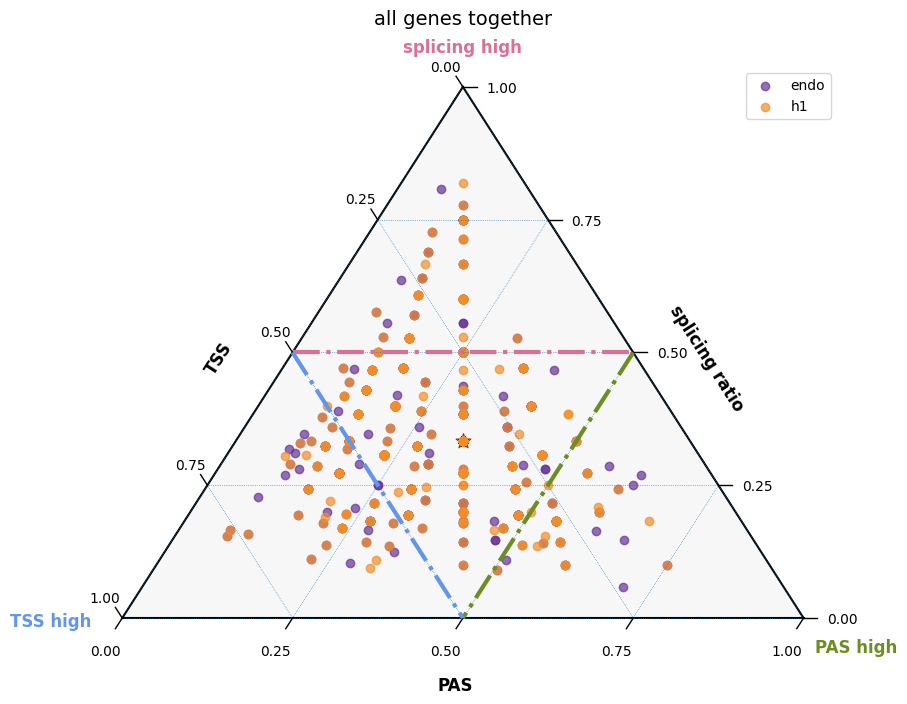

In [23]:
fig, ax = plt.subplots(1, figsize=(8, 7))
triangle_plot(str_var_tab, ax=ax, colors=group_colors, tax_title='all genes together')
fig.tight_layout()

There are genes whose category changes between h1 and endo. Let's look at some examples.

In [24]:
# ENSG00000168615.13 - splicing high in endo, simple in h1
example_gene = 'ENSG00000168615.13'

What does the triangle plot look like for this gene?

/home/train/longTREC/software/miniconda3/envs/isotools/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


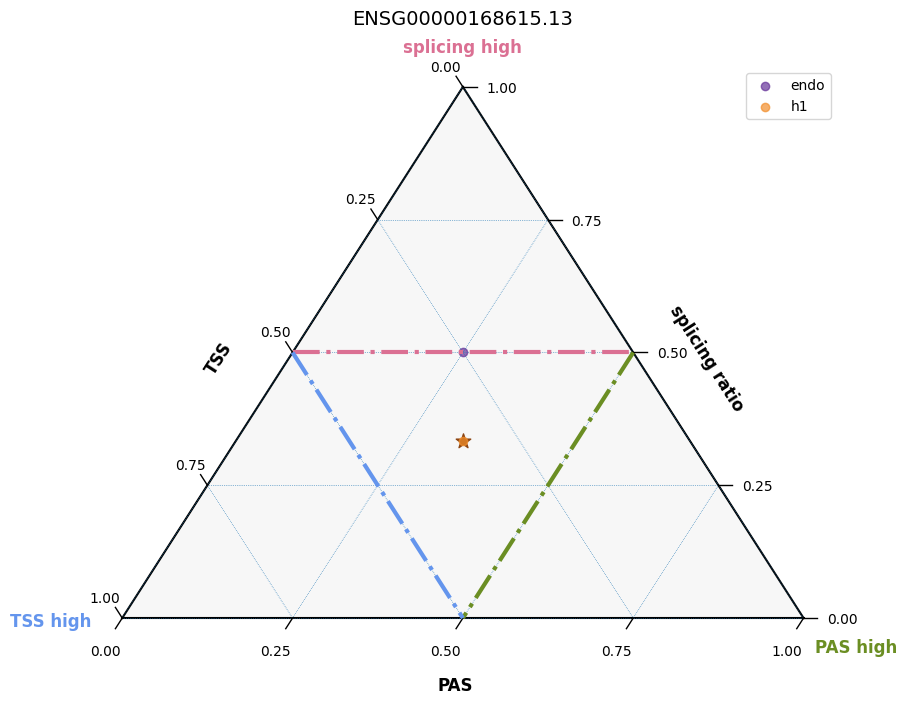

In [25]:
fig, ax = plt.subplots(1, figsize=(8, 7))
triangle_plot(str_var_tab[str_var_tab['gene_id'] == example_gene], ax=ax, colors=group_colors, tax_title=example_gene)
fig.tight_layout()

What are the transcripts like in this gene?

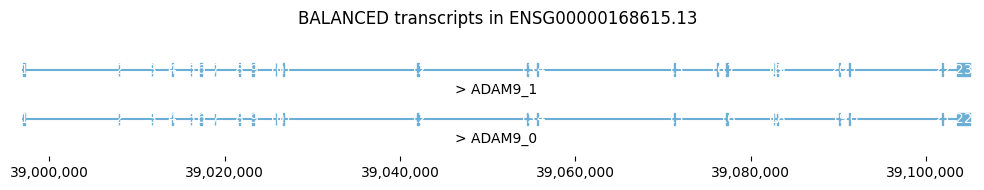

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
transcriptome[example_gene].gene_track(ax=ax, reference=False, query=query_string)
ax.set_title(f"{query_string} transcripts in {example_gene}")
plt.tight_layout()
plt.show()

Please think about ...

- Which transcripts are found in endo and which in h1?
- Where does the structural variation happen?
- Explain how the category is changed between conditions.

Explore some other examples.

### Transcript quantification - entropy

We know the coverage of transcripts. This quantification information can help us to discover genes whose transcript usage changes between groups.

In [27]:
entropy_tab = transcriptome.entropy_calculation(groups=groups, query=query_string, relative=True)

entropy_tab

/home/train/longTREC/software/miniconda3/envs/isotools/lib/python3.12/site-packages/isotools/_transcriptome_stats.py:742: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  entropy_tab = pd.concat(


,gene_id,gene_name,endo_ntr,endo_rel_entropy,h1_ntr,h1_rel_entropy
0,ENSG00000104723.21,TUSC3,5,0.655838,5,0.745192
1,ENSG00000172164.15,SNTB1,2,0.639457,2,0.597598
2,IT_novel_00170,IT_novel_00170,1,NaN,1,NaN
3,ENSG00000253200.1,ENSG00000253200,1,NaN,1,NaN
4,ENSG00000261236.8,BOP1,3,0.147949,3,0.139005
...,...,...,...,...,...,...
795,ENSG00000131203.13,IDO1,4,0.828871,5,0.574685
796,ENSG00000104643.10,MTMR9,2,0.841852,2,0.811278
797,ENSG00000156802.13,ATAD2,2,0.229836,2,0.266765
798,ENSG00000185015.8,CA13,1,NaN,1,NaN


Let's find some examples.

In [28]:
entropy_tab[
    (abs(entropy_tab['endo_rel_entropy'] - entropy_tab['h1_rel_entropy']) >= 0.5)
]

,gene_id,gene_name,endo_ntr,endo_rel_entropy,h1_ntr,h1_rel_entropy
269,ENSG00000170961.7,HAS2,4,0.461390,2,1.000000
628,ENSG00000289405.2,ENSG00000289405,2,0.468996,2,0.985228


In [29]:
# ENSG00000170961.7 - lower entropy in endo, higher in h1
example_gene = 'ENSG00000170961.7'

Let's check the expression intensity of transcripts in these gene between h1 and endo.

/tmp/ipykernel_8406/3786685875.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


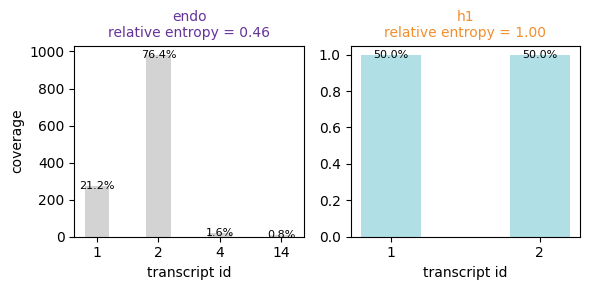

In [30]:
gene_part = transcript_tab.loc[transcript_tab['gene_id'] == example_gene]
entropy_part = entropy_tab.loc[entropy_tab['gene_id'] == example_gene]

# create a 1x2 grid of plots
plt.rcParams["figure.figsize"] = (6, 3)
fig, axs = plt.subplots(1, 2, constrained_layout=True)

for i, group in enumerate(groups):
    group_trs = gene_part.loc[gene_part[group+"_sum_coverage"] > 0, ['transcript_nr', group+"_sum_coverage"]]

    rel_entropy = float(entropy_part[f'{group}_rel_entropy'].values[0])

    # define the color based on relative entropy
    # --- can customize the thresholds as needed ---
    if rel_entropy < 0.3: # low entropy
        tr_color = 'lightcoral'
    elif rel_entropy > 0.7: # medium entropy
        tr_color = 'powderblue'
    else: # high entropy
        tr_color = 'lightgrey'

    # plot the bar chart for each group
    axs[i%2].bar([j for j in range(0,len(group_trs))], group_trs[group+"_sum_coverage"], color =tr_color, width = 0.4)
    
    # add the text on top of the bar
    for j, val in enumerate(group_trs[group+"_sum_coverage"]):
        axs[i%2].text(j, val, f'{val/sum(group_trs[group+"_sum_coverage"])*100:.1f}%', ha='center', va='center', fontsize=8, color='black')
    axs[i%2].set_xticks([j for j in range(0,len(group_trs))])
    axs[i%2].set_xticklabels(group_trs["transcript_nr"])

    if i%2 == 0: axs[0].set_ylabel('coverage')
    axs[i%2].set_xlabel('transcript id')
    axs[i%2].set_title(
        f'{group}\nrelative entropy = {float(entropy_part[f"{group}_rel_entropy"].values[0]):.2f}',
        fontsize=10,
        color=group_colors[group]
    )

    axs[i%2].grid(False)

    # add the ticks for x and y axes
    axs[i%2].tick_params(axis='x', which='both', bottom=True, top=False)
    axs[i%2].tick_params(axis='y', which='both', left=True, right=False)

plt.tight_layout()
plt.show()

What are the transcripts like in this gene?

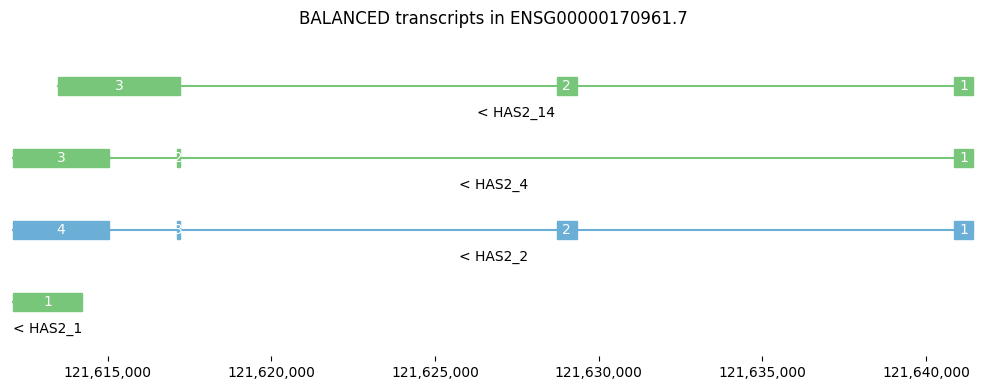

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
transcriptome[example_gene].gene_track(ax=ax, reference=False, colorbySqanti=True, query=query_string)
ax.set_title(f"{query_string} transcripts in {example_gene}")
plt.tight_layout()
plt.show()

Explore some other examples.

## Alternative splicing analysis

### ASE identification

to identify various types of AS events, including:

- exon skipping (ES)
- intron retention (IR)
- mutually exclusive exons (ME)
- 3’ alternative splicing (3AS)
- 5’ alternative splicing (5AS)
- alternative first exons (TSS)
- alternative last exons (PAS)

Firstly, identify the alternative splicing events and summarise the number of each type in a table.

In [32]:
splice_events = transcriptome.alternative_splicing_events()

# count the identified events by type
splice_events.splice_type.value_counts()

splice_type
TSS    260
PAS     96
IR      92
ES      75
5AS     30
3AS     29
ME       2
Name: count, dtype: int64

Two-dimensional embeddings (PCA and UMAP) have been implemented to illustrate the relationship between samples and common ASEs.

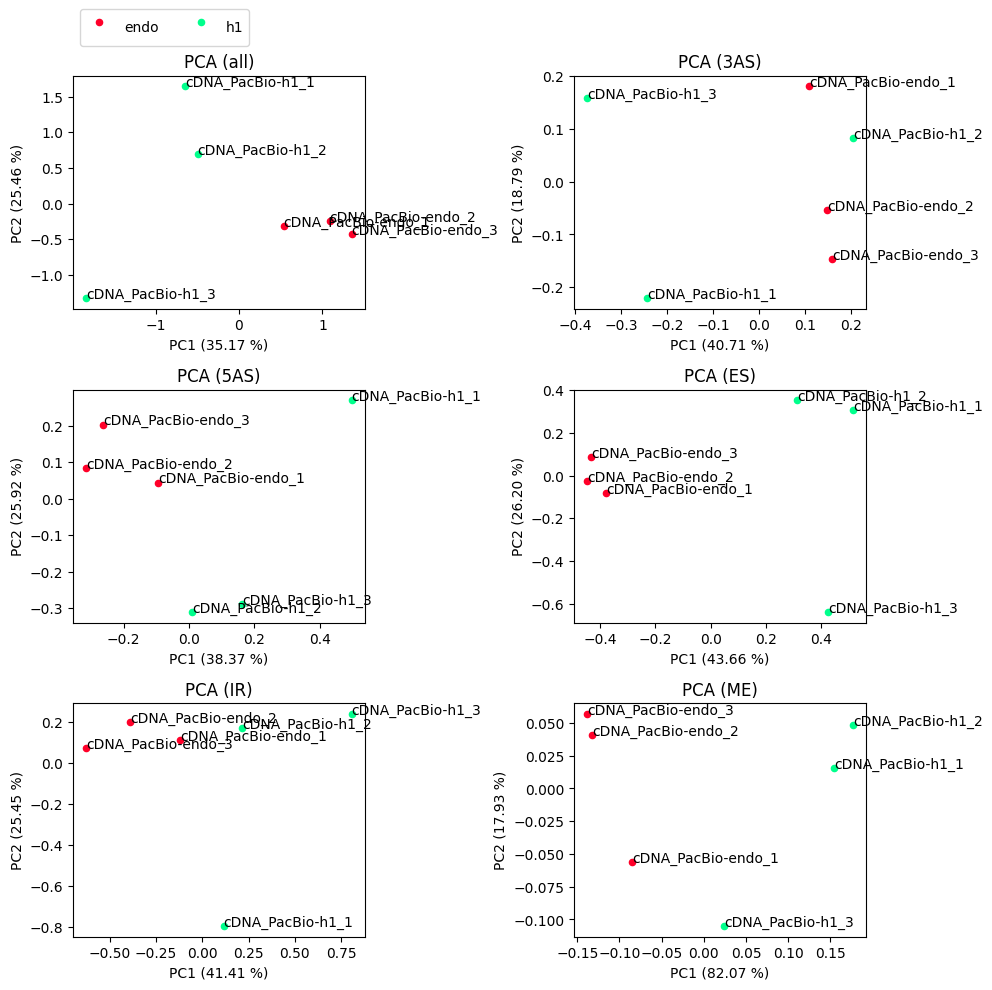

In [33]:
# plot PCA embedding
pca = {}

plt.rcParams["figure.figsize"] = (10, 10)
f,axs = plt.subplots(3, 2)
for ax,t in zip(axs.flatten(), ['all', '3AS', '5AS', 'ES', 'IR', 'ME']):
    pca[t] = plot_embedding(splice_events,
                            ax=ax,
                            labels=True,
                            groups=groups,
                            splice_types=t)
axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05,
                bbox_to_anchor=(0, 1.1), loc='lower left')
plt.tight_layout()

### Differential splicing events

to detect differentially expressed ASEs.

In [34]:
types_of_interest = ['ES','ME','5AS','3AS','IR']

diff_splice = transcriptome.altsplice_test(groups,
                                           types=types_of_interest,
                                           min_total=200)
diff_splice = diff_splice.sort_values('pvalue').reset_index(drop=True)

sig = diff_splice.padj < 0.05
n_genes = len(diff_splice.loc[sig,"gene"].unique())
print(f'{sum(sig)} differential splice sites in {n_genes} genes for '+
      " vs ".join(groups))

INFO:testing differential splicing for endo (3) vs h1 (3) using betabinom_lr test


2 differential splice sites in 2 genes for endo vs h1


In [35]:
pd.set_option('display.max_columns', None)
diff_splice

,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,trA,trB,nmdA,nmdB,endo_PSI,endo_disp,h1_PSI,h1_disp,total_PSI,total_disp,cDNA_PacBio-endo_1_endo_in_cov,cDNA_PacBio-endo_1_endo_total_cov,cDNA_PacBio-endo_2_endo_in_cov,cDNA_PacBio-endo_2_endo_total_cov,cDNA_PacBio-endo_3_endo_in_cov,cDNA_PacBio-endo_3_endo_total_cov,cDNA_PacBio-h1_1_h1_in_cov,cDNA_PacBio-h1_1_h1_total_cov,cDNA_PacBio-h1_2_h1_in_cov,cDNA_PacBio-h1_2_h1_total_cov,cDNA_PacBio-h1_3_h1_in_cov,cDNA_PacBio-h1_3_h1_total_cov
0,TERF1,ENSG00000147601.15,chr8,+,73027052,73032041,ES,False,0.001833,0.000017,"[3, 32, 35, 5, 43, 18, 40, 28, 24, 75, 63, 72,...","[0, 1, 2, 7, 26, 4, 11, 13, 6, 27, 12, 8, 10, ...",1.0,1.0,0.785742,0.000211,0.275682,0.000516,0.530798,0.052928,79,107,54,69,87,104,281,1112,574,2179,177,549
1,CYRIB,ENSG00000153310.22,chr8,-,129871496,129903311,ES,False,0.035052,0.000637,"[11, 7, 25, 33, 28, 88, 90, 31, 36, 42, 46, 47...","[2, 3, 6, 0, 41, 34, 16, 22, 13, 43, 44, 14, 2...",1.0,1.0,0.832346,0.000013,0.638084,0.000010,0.735271,0.009550,143,167,150,188,124,146,72,112,114,175,24,42
2,ESRP1,ENSG00000104413.18,chr8,+,94678371,94705924,ME,False,0.120114,0.003276,"[4, 42, 99, 53, 128, 132, 68, 104, 11, 107, 83...","[1, 36, 10, 28, 31, 9, 73, 12, 91, 61, 96, 67,...",1.0,1.0,0.647632,0.000015,0.357127,0.000049,0.529884,0.014179,36,58,37,56,30,45,11,31,15,45,4,8
3,ESRP1,ENSG00000104413.18,chr8,+,94692827,94705924,ES,False,0.172318,0.006266,"[1, 36, 10, 28, 31, 38, 9, 12, 73, 91, 61, 96,...","[2, 21, 30, 58, 33, 34, 69, 100, 0, 16, 17, 29...",1.0,1.0,0.661283,0.000001,0.818544,0.000009,0.724076,0.003946,70,106,72,109,59,89,50,61,79,95,11,15
4,FOXH1,ENSG00000160973.8,chr8,-,144475223,144475582,3AS,False,0.441114,0.027550,"[1, 6, 19, 21]","[0, 5, 7, 8, 10, 11, 13, 14, 17, 18, 20]",1.0,1.0,0.910682,0.000003,0.848998,0.000019,0.892074,0.000391,272,296,330,367,336,367,83,93,115,138,27,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TMEM64,ENSG00000180694.14,chr8,-,90625862,90645110,ES,False,0.998428,0.984652,[3],"[0, 4]",1.0,1.0,0.897134,0.000004,0.892507,0.000069,0.893840,0.000009,45,49,47,52,39,45,55,58,124,143,35,39
106,ATP6V1H,ENSG00000047249.18,chr8,-,53801896,53814661,ES,False,0.998428,0.988055,"[2, 3, 22, 7, 32, 38, 8, 9, 18]","[0, 1, 29, 4, 6, 13, 5, 10, 12, 17, 19, 20, 23...",1.0,1.0,0.728503,0.000005,0.737406,0.000050,0.731419,0.000020,37,51,42,59,39,52,18,25,31,40,10,15
107,YTHDF3,ENSG00000185728.17,chr8,+,63168814,63169386,5AS,True,0.998428,0.992922,"[0, 6, 18, 19]","[2, 5, 1, 3, 10, 12, 4, 7, 8, 9, 11, 21, 26, 27]",1.0,1.0,0.884195,0.000004,0.888185,0.000003,0.886101,0.000002,69,80,89,100,79,88,73,84,87,96,15,17
108,SDCBP,ENSG00000137575.12,chr8,+,58572314,58575902,3AS,False,0.998428,0.994183,"[1, 3, 13, 4, 38, 33, 5, 6, 36, 8, 41, 22, 25]","[0, 2, 14, 16, 27, 15, 30, 31, 7, 9, 11, 12, 2...",1.0,1.0,0.727816,0.000004,0.730833,0.000018,0.728251,0.000005,239,339,338,457,297,405,66,86,111,159,32,41


IsoTools implements a specific plot to depict differential splicing results. The curves show the distribution of the posterior probability of PSI values for the two groups, while the dots represent the observed PSI values for individual samples.

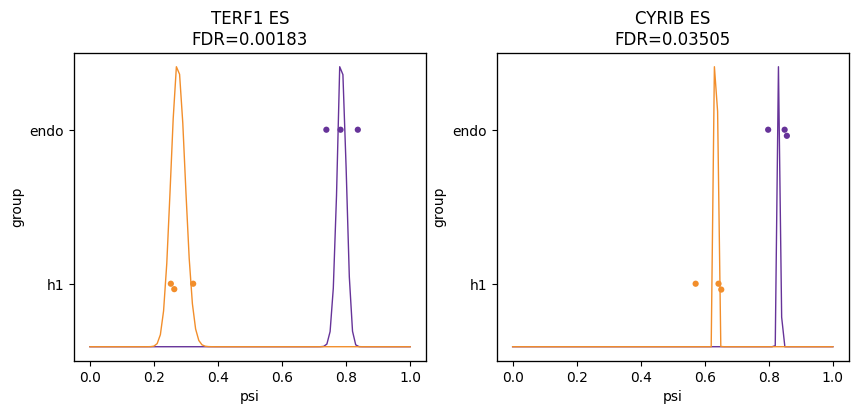

In [36]:
plt.rcParams["figure.figsize"] = (10,4)

f,axs,plotted = plot_diff_results(diff_splice,
                                  min_diff=0.1,
                                  min_support=2,
                                  grid_shape=(1,2),
                                  group_colors=group_colors)

Additionally, the structure of the isoforms and the read coverage over the event can be visualised using a sashimi plot.

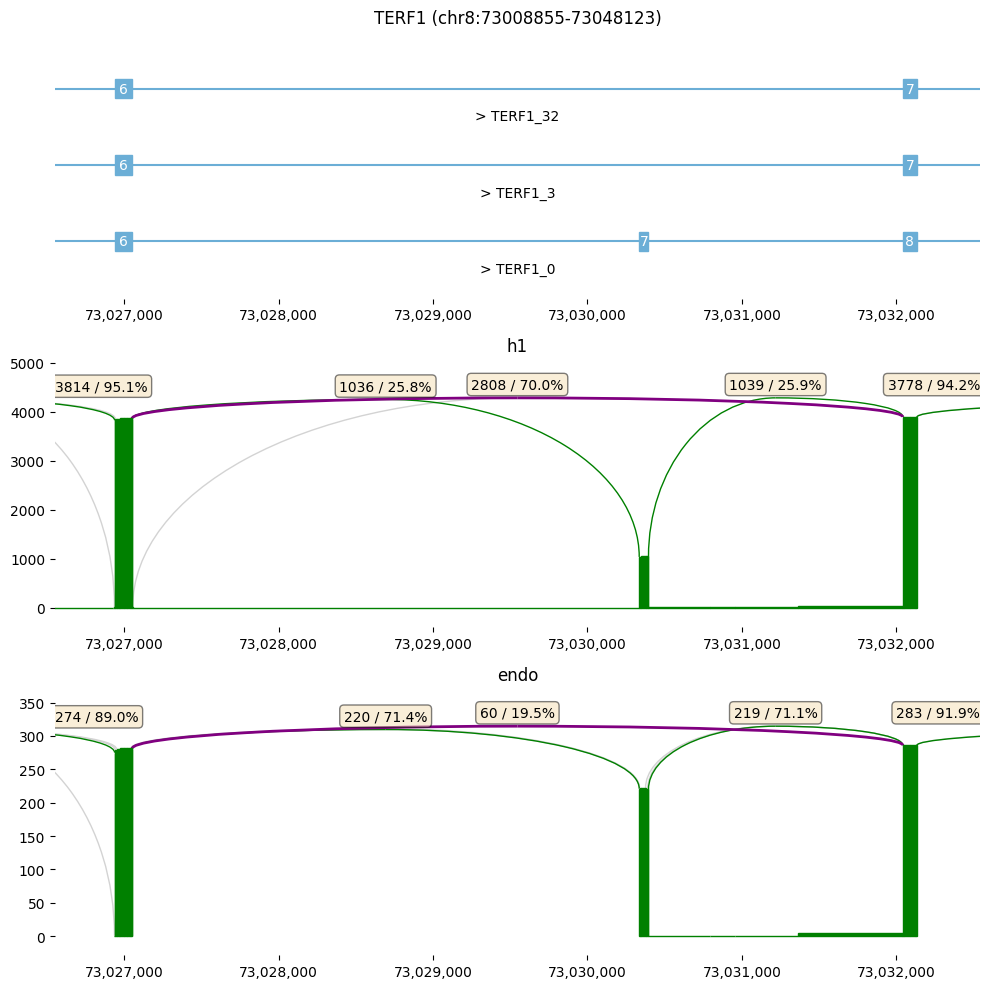

In [37]:
row = diff_splice.iloc[0]

plt.rcParams["figure.figsize"] = (10,10)
pos = [row['start']-500, row['end']+500]
joi = [(row['start'], row['end'])]
fig,axs = plt.subplots(3)
gene = transcriptome[row['gene_id']]
gene.gene_track(x_range=pos,
                ax=axs[0],
                reference=False,
                select_transcripts=gene.filter_transcripts('SUBSTANTIAL'))
gene.sashimi_plot(samples=groups['h1'],
                  junctions_of_interest=joi,
                  x_range=pos,
                  ax=axs[1],
                  title='h1',
                  log_y=False)
gene.sashimi_plot(samples=groups['endo'],
                  junctions_of_interest=joi,
                  x_range=pos,
                  ax=axs[2],
                  title='endo',
                  log_y=False)

fig.tight_layout()

## Conclusion

In this hands-on practice, we have explored some features of IsoTools for long-read transcriptomics analysis, including:

- transcriptome reconstruction from long-read alignments with quality control  
- data export in multiple formats (gtf, fasta, pickle) for downstream analysis  
- gene model characterization using simplex coordinates for structural variation and relative entropy for expression variation  
- ASE detection and differential splicing analysis between conditions

Long-read data enables the comprehensive detection of transcript isoforms and splicing events. However, quality control is crucial for meaningful biological interpretation.

IsoTools provides flexible filtering options to remove technical artifacts (e.g. internal priming, template switching and fragments) and offers various options for downstream analysis and visualisation.

**Further analysis**:
- differential isoform usage
- functional annotation of transcripts
- pathways and functional domains affected by splicing

**Happy long-read transcriptomics analysis!** 🧬📊